# Importação de módulos

In [194]:
%matplotlib inline
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras import backend as K
import psutil
import os 
from keras.models import Sequential
from keras.layers import Dense, Activation
#from keras.layers import Dropout
from keras.utils import np_utils
#from keras.layers import Flatten
#from keras.layers.convolutional import Convolution2D
#from keras.layers.convolutional import MaxPooling2D
#from keras import backend as K
K.set_image_dim_ordering('th')
import time

num_cores = psutil.cpu_count()
GPU= True

if GPU:
    num_GPU = 1
    num_CPU = 1
    print('Usando a GPU')
else:
    num_CPU = 1
    num_GPU = 0
    print('Usando apenas o CPU')

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

Usando a GPU


# Tratamento de Dados

### Carregamento de dados

In [223]:
mnist = np.loadtxt('exdata.csv', delimiter=',')

data = mnist[:-1].T
data = np.array(list(map(lambda d: d.reshape((20,20)).T.flatten(), data)))
target = mnist[-1]

target[target == 10] = 0

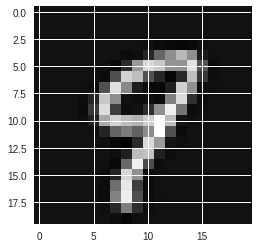

In [224]:
a = data[4800]
plt.imshow(a.reshape((20,20)), cmap=plt.get_cmap('gray'))

### Normalização de dados

A normalização da saída é feita utilizando OneHotEncoder, que transforma aquela saída única em um vetor colocando 0 paras as outras possíveis saídas da rede e 1 para a saída correta.

In [225]:
data_normalized = data

target_scaler = OneHotEncoder()
target_normalized = target_scaler.fit_transform(target.reshape((-1, 1))).todense()

### Separação de dados treinano/teste


Foi separado 15% dos dados para formarem o conjunto de teste.

In [226]:
data_train, data_test, target_train, target_test = train_test_split(
    data_normalized,
    target_normalized,
    train_size=(85/100),
)

## Definição da arquitetura


A rede é configurada da seguinte forma: a camada de entrada com 400 neurônios, a hidden layer com 205 neurônios e a camada de saída com 10 neurônios.

In [227]:
def mlp():
    model = Sequential()
    model.add(Dense(205, input_dim=400, kernel_initializer="normal"))
    model.add(Activation('relu'))
    model.add(Dense(10, kernel_initializer="normal"))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Treinamento da rede

In [228]:
model = mlp()

start_time = time.time()

treinar = True
if treinar:
    print("Treinando a rede")
    model.fit(data_train, target_train, validation_data=(data_test, target_test), epochs=100, batch_size=150, verbose=0)
    model.save_weights("mlp.h5")
    print("Pesos salvos")
else:
    model.load_weights("mlp.h5")
    print("Pesos recuperados do disco")

scores = model.evaluate(data_test, target_test, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Rede treinada/buscada em %.2f segundos" % (time.time() - start_time))

Treinando a rede
Pesos salvos
Baseline Error: 6.00%
Rede treinada/buscada em 17.61 segundos


## Resultados

#### Teste Utilizando Todos os Dados

In [229]:
predictions_all = model.predict(data_normalized)
predictions_all = np.argmax(predictions_all, axis=1)
print("Test set accuracy: {:.2%}".format(
    metrics.accuracy_score(target, predictions_all)))

Test set accuracy: 99.10%



Matriz de confusão para todo o conjunto de dados.

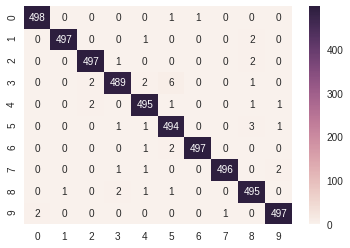

In [230]:
confusion_matrix = metrics.confusion_matrix(target, predictions_all)
sn.heatmap(confusion_matrix, annot=True, fmt='d')

In [231]:
print(metrics.classification_report(target, predictions_all))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       500
        1.0       1.00      0.99      1.00       500
        2.0       0.99      0.99      0.99       500
        3.0       0.99      0.98      0.98       500
        4.0       0.99      0.99      0.99       500
        5.0       0.98      0.99      0.98       500
        6.0       1.00      0.99      1.00       500
        7.0       1.00      0.99      0.99       500
        8.0       0.98      0.99      0.99       500
        9.0       0.99      0.99      0.99       500

avg / total       0.99      0.99      0.99      5000



#### Teste Utilizando Apenas o Conjunto de Teste

In [232]:
predictions = model.predict(data_test)
predictions = np.argmax(predictions, axis=1)
target_test_classes = np.asarray(target_test.argmax(axis=1)).reshape(-1)
print("Test set accuracy: {:.2%}".format(
    metrics.accuracy_score(target_test_classes, predictions)))

Test set accuracy: 94.00%



Matriz de confusão para o conjunto teste.

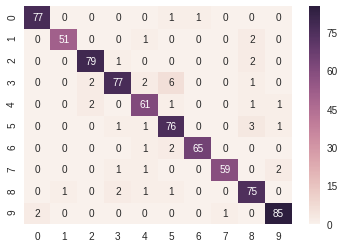

In [233]:
confusion_matrix = metrics.confusion_matrix(target_test_classes, predictions)
sn.heatmap(confusion_matrix, annot=True, fmt='d')

In [234]:
print(metrics.classification_report(target_test_classes, predictions))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97        79
          1       0.98      0.94      0.96        54
          2       0.95      0.96      0.96        82
          3       0.94      0.88      0.91        88
          4       0.90      0.92      0.91        66
          5       0.87      0.93      0.90        82
          6       0.98      0.96      0.97        68
          7       0.98      0.94      0.96        63
          8       0.89      0.94      0.91        80
          9       0.96      0.97      0.96        88

avg / total       0.94      0.94      0.94       750



In [251]:
from PIL import Image
import matplotlib.image as mpimg
from resizeimage import resizeimage


with open('5.png', 'r+b') as f:
    with Image.open(f) as image:
        cover = resizeimage.resize_cover(image, [20, 20]).convert('L')
        cover.save('5inho.png', image.format)
img = mpimg.imread('5inho.png').flatten()
img.shape
img2 = np.vstack((data_scaler.fit_transform(img),data_scaler.fit_transform(img)))
y = model.predict(img2)
output = y.argmax(axis=1)
print(y[0][output])
print(output)

[ 1.  1.]
[1 1]


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

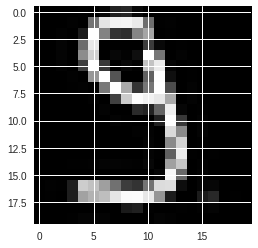

In [239]:
plt.imshow(img.reshape((20,20)), cmap=plt.get_cmap('gray'))